In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

# train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each


In [4]:
trained_reasoner.load_state_dict(torch.load('local/out/exp/20220715T194304/reasoner.pt'))

<All keys matched successfully>

In [5]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te, None, reasoner, test_encoders, epoch_count=15, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/15 | batch 1251/1250 | loss 1.3762 | val loss 1.3762 | acc 0.5908 | f1 0.4043 | prec 0.2958 | recall 0.6387 | roc auc 0.6737 | pr auc 0.4916 | elapsed 14.98s
train epoch 01/15 | batch 1251/1250 | loss 1.1162 | val loss 0.8434 | acc 0.7027 | f1 0.4897 | prec 0.3906 | recall 0.6559 | roc auc 0.7563 | pr auc 0.5832 | elapsed 30.64s
train epoch 02/15 | batch 1251/1250 | loss 0.6861 | val loss 0.5182 | acc 0.8030 | f1 0.6019 | prec 0.5368 | recall 0.6850 | roc auc 0.8329 | pr auc 0.6953 | elapsed 28.56s
train epoch 03/15 | batch 1251/1250 | loss 0.4375 | val loss 0.3438 | acc 0.8720 | f1 0.7078 | prec 0.7025 | recall 0.7131 | roc auc 0.8880 | pr auc 0.7973 | elapsed 29.62s
train epoch 04/15 | batch 1251/1250 | loss 0.3070 | val loss 0.2540 | acc 0.9100 | f1 0.7816 | prec 0.8270 | recall 0.7409 | roc auc 0.9226 | pr auc 0.8629 | elapsed 28.99s
train epoch 05/15 | batch 1251/1250 | loss 0.2379 | val loss 0.2040 | acc 0.9297 | f1 0.8250 | prec 0.8999 | recall 0.

In [6]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240709T133847


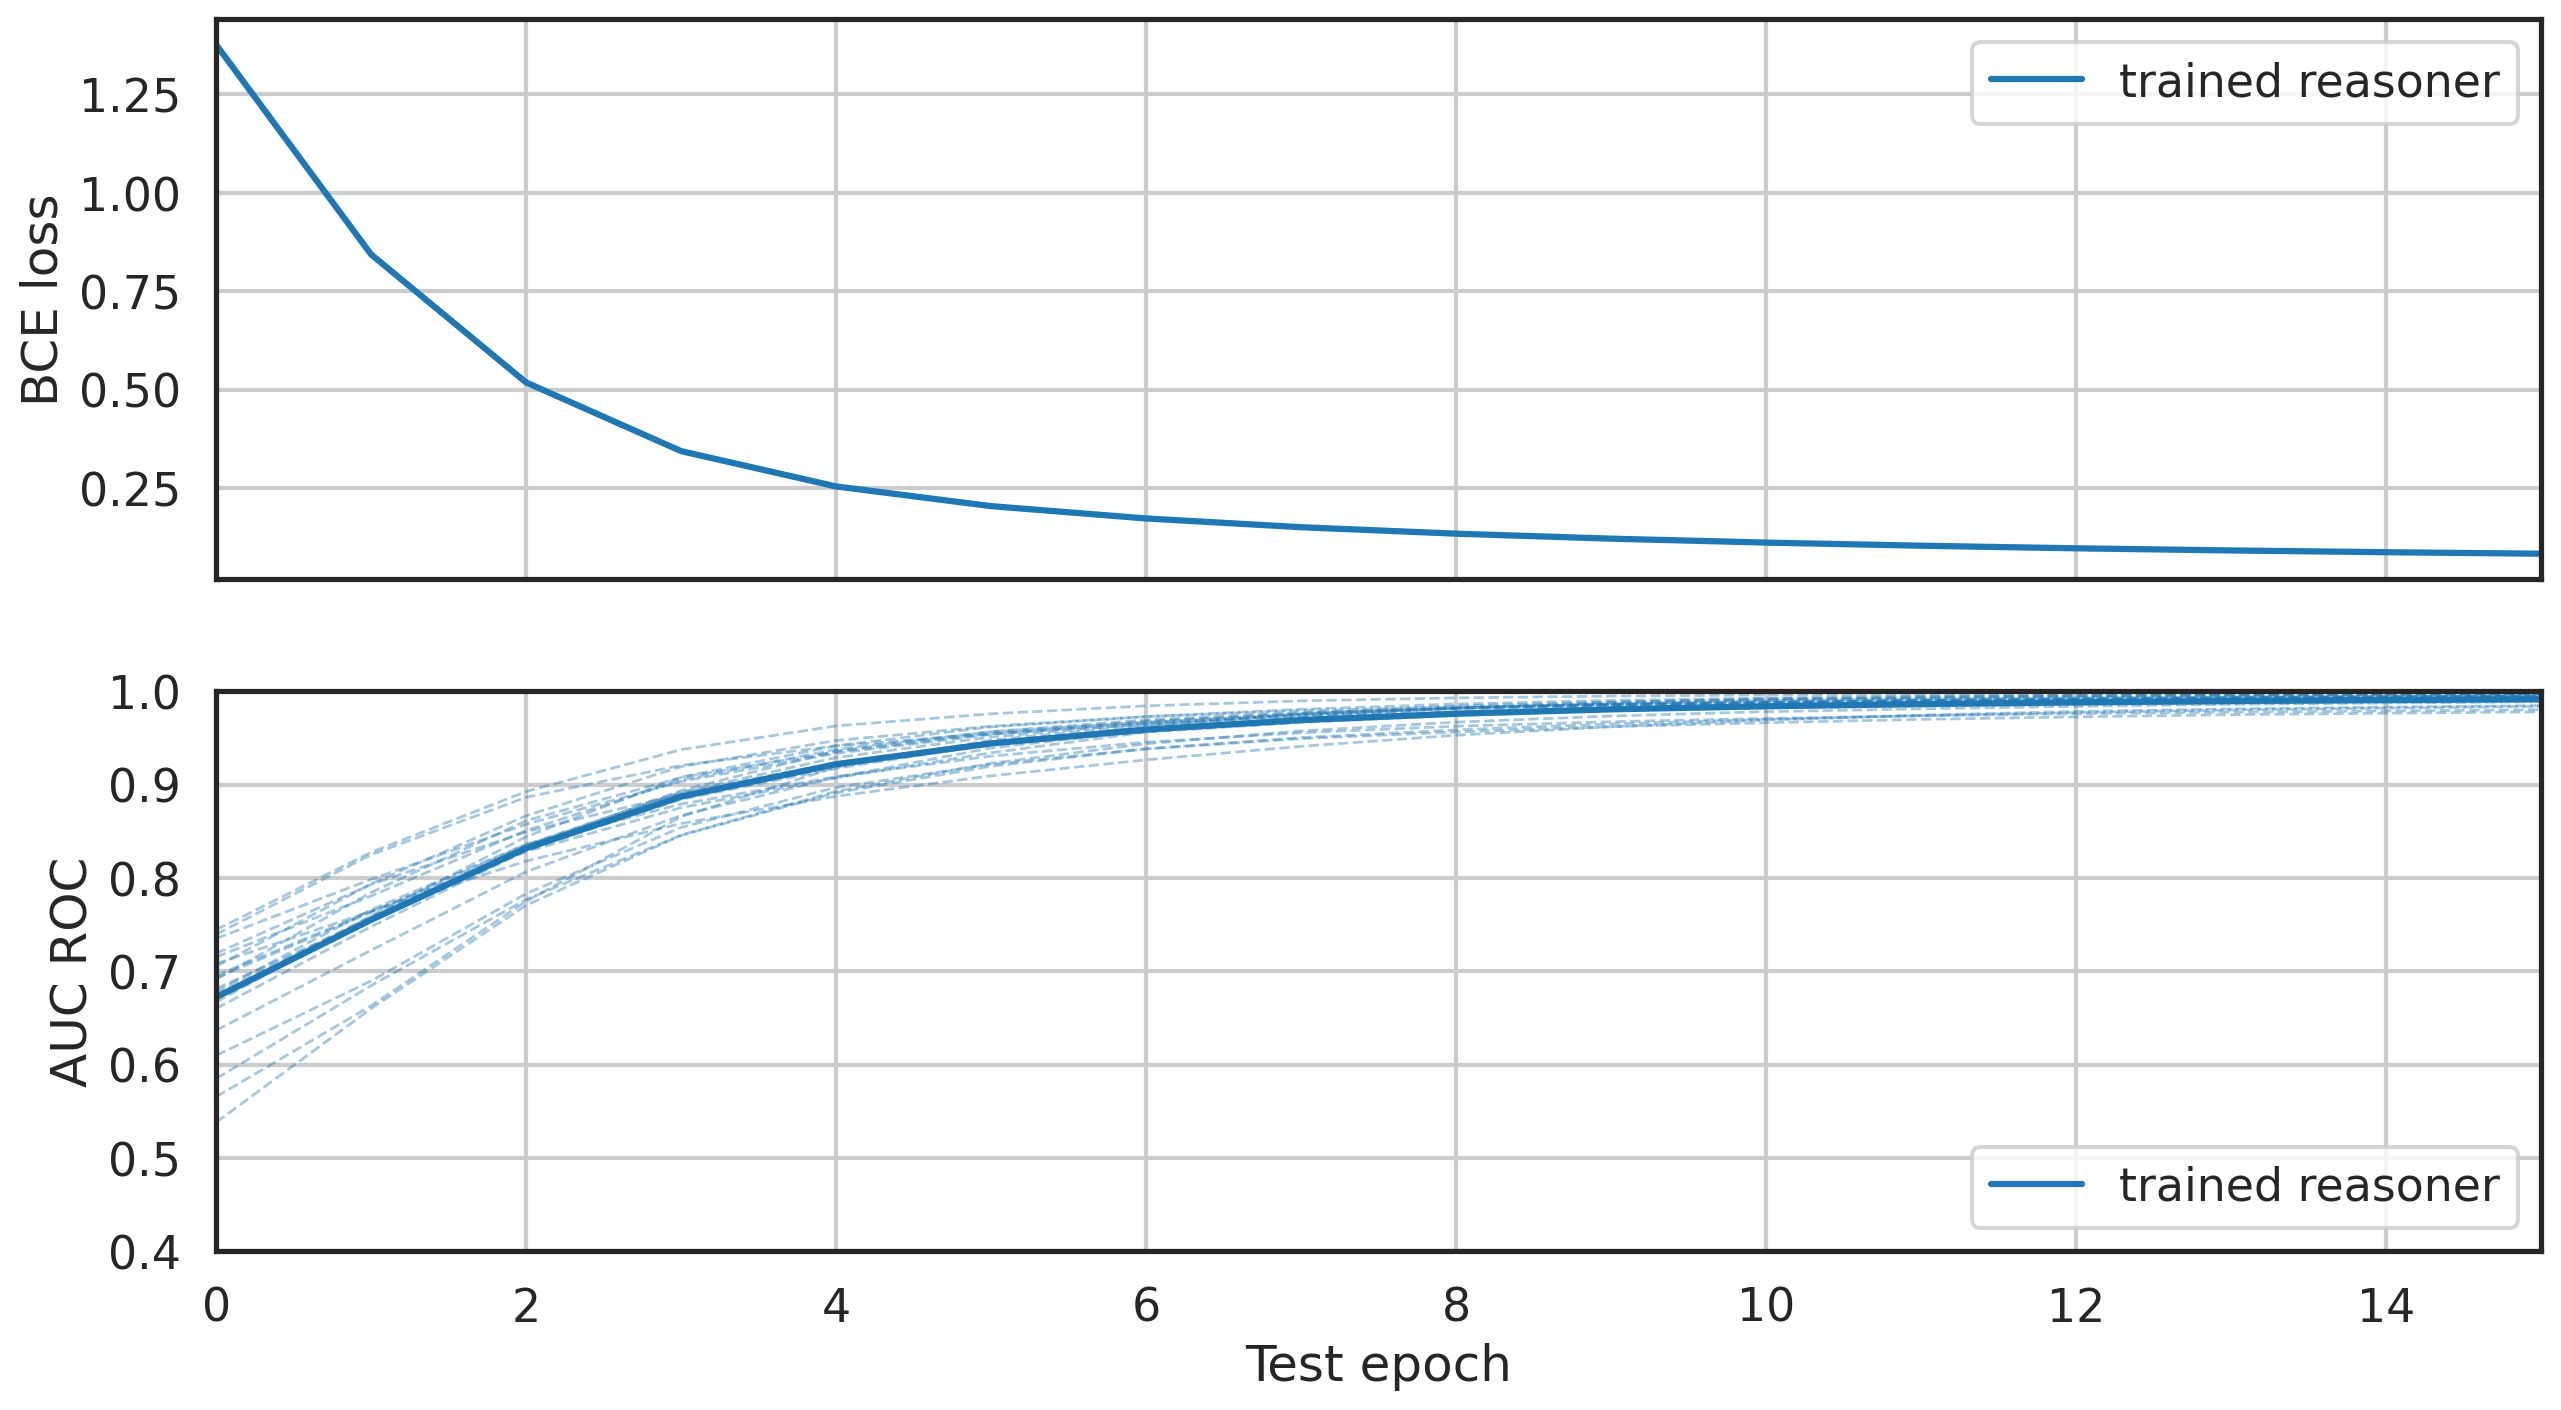

             mean       std     micro
acc      0.970075  0.013490  0.970075
prec     0.974969  0.020204  0.975041
recall   0.883629  0.043826  0.885005
f1       0.926791  0.032094  0.927844
auc_roc  0.991502  0.005910  0.992443
auc_pr   0.978595  0.013879  0.980782


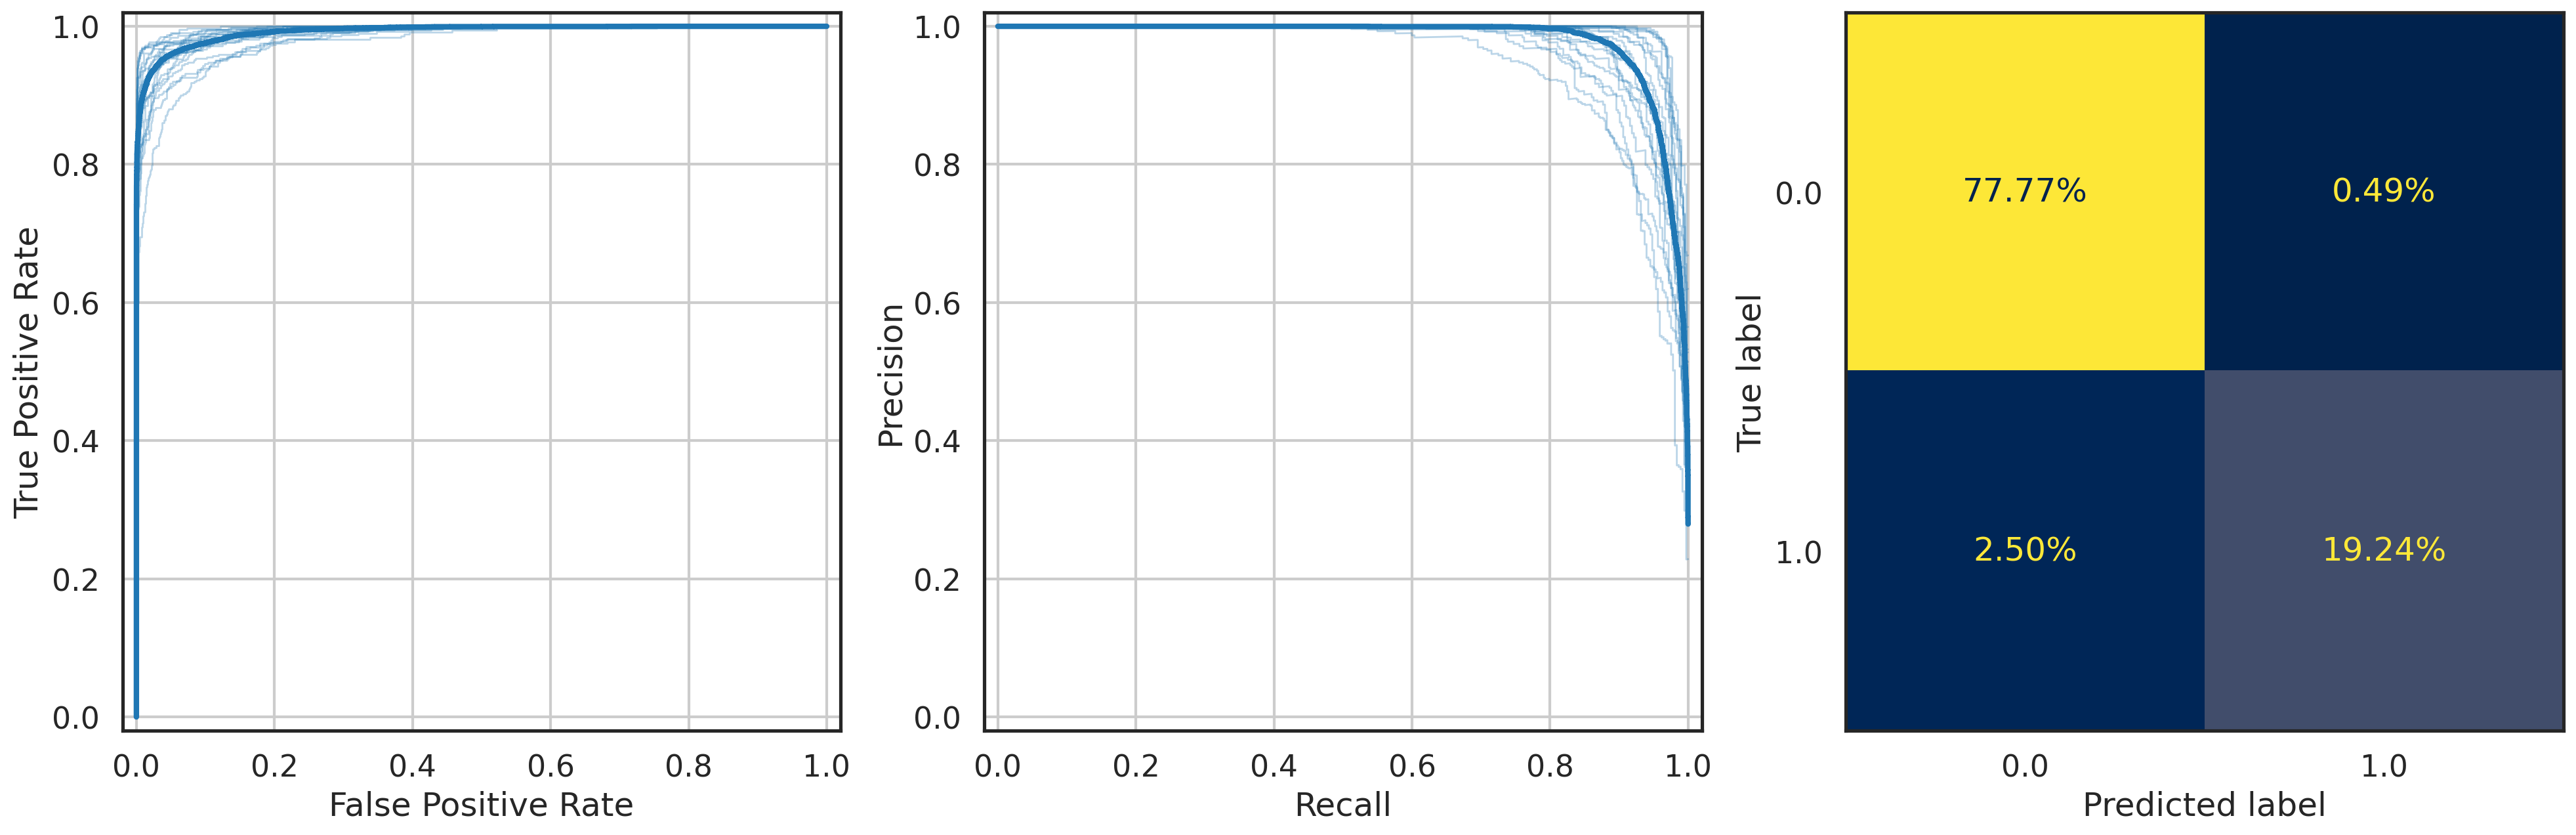

In [7]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)


test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))
plot_test_history(test_history, test_history_by_onto,)
print(report(test_onto, y_te, np.array(Y_te_good), idx_te))
